In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter

In [3]:
train = pd.read_csv('./datasets/titanic_train.csv')
test  = pd.read_csv('./datasets/titanic_test.csv')

## Data preparation

In [4]:
data = pd.concat([train, test])

data['Age'] = data['Age'].fillna(data['Age'].median())
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

data.Sex, mapper_sex      = pd.factorize(data.Sex)
data.Embarked, mapper_emb = pd.factorize(data.Embarked)
data.Pclass = 1 - (data.Pclass == 3).astype(int)

to_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name', 'Embarked']# 'Embarked', 'Pclass', 'Parch', 'Sex', 'SibSp']
data.drop(to_drop, axis=1, inplace=True)

maxs = data.drop("Survived", axis=1).max()

data.head()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived
0,22.0,7.2500,0,0,0,1,0.0
1,38.0,71.2833,0,1,1,1,1.0
2,26.0,7.9250,0,0,1,0,1.0
3,35.0,53.1000,0,1,1,1,1.0
4,35.0,8.0500,0,0,0,0,0.0


In [5]:
train = data[~pd.isnull(data.Survived)].fillna(0.0)
test  = data.loc[pd.isnull(data.Survived)].fillna(0.0)

test.drop('Survived', axis=1, inplace=True)

### The good model

In [39]:
train_x = train.drop('Survived', axis=1)
train_y = train.Survived

rf = RandomForestClassifier(n_estimators=250)
rf.fit(train_x, train_y)

preds = rf.predict_proba(test)

### The noisy model

In [50]:
class NoisyRf(RandomForestClassifier):
    def predict_proba(self, test_set):
        preds_1 = super(NoisyRf, self).predict_proba(test_set)[:,1]
        preds_1 += np.random.normal(0, 0.3, size=preds_1.shape)
        preds_1 = np.array(list(map(lambda x: 0 if x < 0 else 1 if x > 1 else x, preds_1)))
        return preds_1

    def predict(self, test_set):
        probas = self.predict_proba(test_set)
        return (probas > 0.5).astype(int)

In [51]:
noisy_rf = NoisyRf(n_estimators=250)
noisy_rf.fit(train_x, train_y)

noisy_preds = noisy_rf.predict_proba(test)

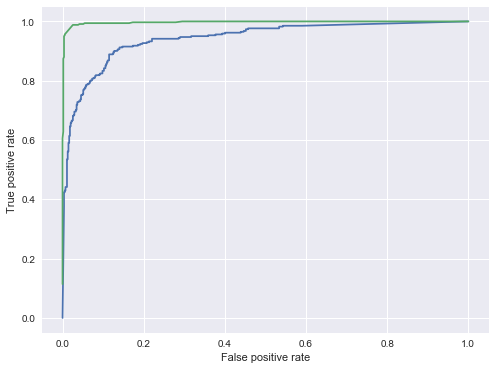

In [52]:
from sklearn.metrics import roc_curve

train_pred = rf.predict_proba(train_x)
train_pred_no = noisy_rf.predict_proba(train_x)

fpr_t, tpr_t, thres_t = roc_curve(train_y, train_pred_no)
fpr_v, tpr_v, thres_v = roc_curve(train_y, train_pred[:,1])

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(8,6))
plt.plot(fpr_t, tpr_t, '-')
plt.plot(fpr_v, tpr_v, '-')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Pick random points in the dataset

In [91]:
pts_ids = np.random.randint(test.shape[0], size=(15))
points = test.iloc[pts_ids]

In [93]:
pred, bias, contrib = treeinterpreter.predict(rf, points)
contrib = pd.DataFrame(contrib[:,:,1], columns=test.columns)

In [79]:
c = contrib.iloc[14]

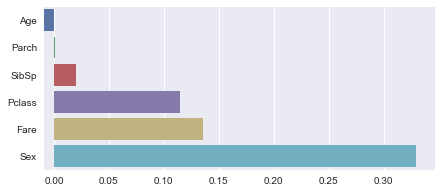

In [81]:
fig = sns.plt.figure(figsize=(7, 3))

srtd = c.sort_values()
sns.barplot(srtd.values, srtd.index)

fig.savefig('../report/img/titanic-treeinterpreter-rich.svg')

In [82]:
cumsum = np.array([sum(c.values[:i]) for i in range(c.shape[0] + 1)]) + bias[14, 1]
labels = ['Base'] + c.index.tolist()

In [83]:
cumsum

array([ 0.3845477 ,  0.37541332,  0.51147835,  0.5121517 ,  0.62669582,
        0.95619155,  0.976     ])

In [84]:
freq = 100.0
xlbl = []
for l in labels:
    xlbl.append(l)
    xlbl.append("")

x = [i / 2 if i % 2 == 0 else int(i / 2) + 0.99 for i in range(len(xlbl))]

y = [cumsum[i / 2] for i in range(len(xlbl))]

/Users/marcbeillevaire/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


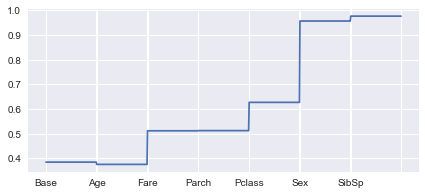

In [85]:
fig = plt.figure(figsize=(7, 3))

plt.xticks(x, xlbl)
plt.plot(x,y)
plt.show()

fig.savefig('../report/img/1-2-2.svg')

## Mode features influence

In [86]:
test.median()

Age       28.0000
Fare      14.4542
Parch      0.0000
Pclass     0.0000
Sex        0.0000
SibSp      0.0000
dtype: float64

In [87]:
pred, bias, contrib = treeinterpreter.predict(rf, test.mode())
contrib = pd.DataFrame(contrib[:,:,1], columns=test.columns)

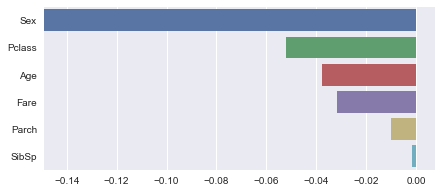

In [88]:
fig = plt.figure(figsize=(7, 3))

c = contrib.loc[0]
srtd = c.sort_values()
sns.barplot(srtd.values, srtd.index)

fig.savefig('../report/img/titanic-treeint-mode.svg')